by Prakash Srivastava and Samarth Goel

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import yfinance as yf
from itertools import combinations
from statsmodels.tsa.stattools import coint

#!pip install arch
from arch.unitroot.cointegration import phillips_ouliaris

In [2]:
url = 'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey=demo'
c=pd.read_csv(url)

In [3]:
etfs = c[c['assetType']=='ETF']
etfs = etfs[etfs['status'] == 'Active']
etfs['ipoDate'] = pd.to_datetime(etfs['ipoDate'])
etfs = etfs[etfs['ipoDate'] < '01-01-2020']
etfs.sort_values(by='ipoDate', inplace=True, ascending=True)

In [4]:
etfs

,symbol,name,exchange,assetType,ipoDate,delistingDate,status
593,ASA,ASA Gold and Precious Metals Ltd,NYSE,ETF,1978-01-03,NaN,Active
8762,TY,TriContinental Corp,NYSE,ETF,1983-04-06,NaN,Active
137,ADX,Adams Express Company,NYSE,ETF,1984-07-19,NaN,Active
897,BCV,Bancroft Fund Ltd,NYSE MKT,ETF,1984-09-07,NaN,Active
4574,INSI,Insight Select Income Fund,NYSE,ETF,1984-09-07,NaN,Active
...,...,...,...,...,...,...,...
2458,DWAW,AdvisorShares Dorsey Wright FSM All Cap World ETF,NASDAQ,ETF,2019-12-27,NaN,Active
2460,DWEQ,AdvisorShares Dorsey Wright Alpha Equal Weight...,NASDAQ,ETF,2019-12-27,NaN,Active
2470,DWUS,AdvisorShares Dorsey Wright FSM US Core ETF,NASDAQ,ETF,2019-12-27,NaN,Active
4889,JOYY,Infusive Compounding Global Equities ETF,NYSE ARCA,ETF,2019-12-30,NaN,Active


Get data for all ETFs that have been around for at least a year.

In [28]:
n = 200    # we're gonna examine the n (200) oldest ETFS

tickers = list(etfs.head(n)['symbol'])
data = yf.download(tickers=tickers, period='60d', interval='15m', threads=True)
data = data['Adj Close'].dropna(axis=1, how='all')
data.head(5)

[*********************100%***********************]  200 of 200 completed

1 Failed download:
- NTX: No data found, symbol may be delisted


,ADX,ASA,ASG,AWF,BCV,BIF,BKN,BKT,BTO,CEE,...,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,ZTR
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-10 09:30:00-04:00,16.438299,23.434601,7.2400,10.6900,25.299999,10.2599,16.2600,6.1950,22.530001,20.780001,...,65.239998,33.730000,25.059999,77.980003,117.709999,65.195000,59.250000,105.934998,150.020004,7.8766
2020-09-10 09:45:00-04:00,16.400000,23.360001,7.2332,10.7167,25.299999,10.2300,16.2600,6.1970,22.890699,NaN,...,65.269997,33.630001,25.059999,77.800003,117.559998,65.150002,59.099998,105.790001,149.639999,7.8700
2020-09-10 10:00:00-04:00,16.420000,23.330000,7.2299,10.7300,25.475000,10.2500,NaN,6.2000,22.847700,NaN,...,65.199997,33.669998,25.010000,77.760002,117.870003,65.019997,59.130001,105.779999,149.789993,7.8601
2020-09-10 10:15:00-04:00,16.389999,23.260000,7.2301,10.7200,25.475000,10.2518,NaN,6.1950,22.823400,NaN,...,64.989998,33.599998,25.000000,77.489998,117.320000,65.019997,59.200001,105.730003,149.460007,7.9000
2020-09-10 10:30:00-04:00,16.420000,23.257999,7.2360,10.7120,25.400000,10.2530,16.2875,6.1901,22.840000,NaN,...,65.089996,33.583199,24.990000,77.589996,117.139999,65.239998,59.450001,105.989998,149.389999,7.8800


In [29]:
returns = pd.DataFrame(np.diff(np.log(data), axis=0), columns = data.columns, index=data.index[1:]).dropna(axis=1, how='all')
returns.head(5)

,ADX,ASA,ASG,AWF,BCV,BIF,BKN,BKT,BTO,CEE,...,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,ZTR
Datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-10 09:45:00-04:00,-0.002333,-0.003188,-0.000940,0.002495,0.000000,-0.002919,0.0,0.000323,0.015883,NaN,...,0.000460,-0.002969,0.000000,-0.002311,-0.001275,-0.000690,-0.002535,-0.001370,-0.002536,-0.000838
2020-09-10 10:00:00-04:00,0.001219,-0.001285,-0.000456,0.001240,0.006893,0.001953,NaN,0.000484,-0.001880,NaN,...,-0.001073,0.001189,-0.001997,-0.000514,0.002634,-0.001997,0.000508,-0.000095,0.001002,-0.001259
2020-09-10 10:15:00-04:00,-0.001829,-0.003005,0.000028,-0.000932,0.000000,0.000176,NaN,-0.000807,-0.001064,NaN,...,-0.003226,-0.002081,-0.000400,-0.003478,-0.004677,0.000000,0.001183,-0.000473,-0.002205,0.005063
2020-09-10 10:30:00-04:00,0.001829,-0.000086,0.000816,-0.000747,-0.002948,0.000117,NaN,-0.000791,0.000727,NaN,...,0.001537,-0.000500,-0.000400,0.001290,-0.001535,0.003378,0.004214,0.002456,-0.000469,-0.002535
2020-09-10 10:45:00-04:00,-0.008563,-0.007683,0.002622,0.000747,-0.002760,-0.004203,NaN,0.000275,0.003409,NaN,...,-0.005237,-0.005769,-0.007632,-0.005493,-0.009263,-0.006459,-0.005059,-0.006911,-0.007728,-0.005089


In [30]:
def engle_granger(ticker1, ticker2):
    df = returns[[ticker1,ticker2]].copy()
    total_observations = len(df)
    df.dropna(inplace=True)
    common_observations = len(df)
    threshold_met = True
    if common_observations / total_observations < 0.95:  # checks if at most 5% of the data was dropped
        threshold_met = False
    if total_observations < 5:
        return float('inf'), 1, False
    r = coint(df[ticker1], df[ticker2])
    return r[0], r[1], threshold_met

In [31]:
cointegrated_pairs = pd.DataFrame({'ticker1':[], 'ticker2':[], 'test_statistic':[], 'p_value':[]})

In [32]:
import warnings
warnings.filterwarnings("error")

In [33]:
for item in combinations(returns.columns, 2):
    try:
        res = engle_granger(item[0], item[1])
        if res[2]:  # less than 5% of the data was dropped for being missing
            if res[1] < 0.001:  # p-value less than 0.001
                cointegrated_pairs = cointegrated_pairs.append({'ticker1':item[0], 'ticker2':item[1], 'test_statistic':res[0], 'p_value':res[1]}, ignore_index=True)
    except Exception as e:
        pass

In [34]:
cointegrated_pairs

,ticker1,ticker2,test_statistic,p_value
0,ADX,AWF,-22.413997,0.0
1,ADX,CEF,-21.520043,0.0
2,ADX,CRF,-43.781079,0.0
3,ADX,DIA,-32.218325,0.0
4,ADX,DNP,-21.817889,0.0
...,...,...,...,...
873,XLP,XLV,-40.927787,0.0
874,XLP,XLY,-25.017271,0.0
875,XLU,XLV,-41.010945,0.0
876,XLU,XLY,-22.206499,0.0


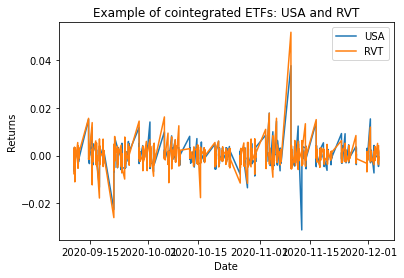

In [35]:
plt.plot(returns['USA'], label='USA')
plt.plot(returns['RVT'], label='RVT')
plt.legend()
plt.ylabel('Returns')
plt.xlabel('Date')
plt.title('Example of cointegrated ETFs: USA and RVT')
plt.show();

Notice how there was a pair trading opportunity just before November 15, when USA fell sharply compared to RVT but then its returns reverted to following RVT.

Lets conduct another test for cointegration to narrow down the universe of cointegrated ETFs.

In [36]:
def phillips_ouliaris_test(ticker1, ticker2):
    df = returns[[ticker1, ticker2]].copy()
    total_observations = len(df)
    df.dropna(inplace=True)
    common_observations = len(df)
    threshold_met = True
    if common_observations / total_observations < 0.95:  # checks if at most 5% of the data was dropped
        threshold_met = False
    if total_observations < 5:
        return float('inf'), 1, False
    r = phillips_ouliaris(df[ticker1].values, df[ticker2].values)
    return r.stat, r.pvalue, threshold_met

In [37]:
cointegrated_pairs_filtered = pd.DataFrame({'ticker1':[], 'ticker2':[], 'eg_test_statistic':[], 'eg_p_value':[], 'po_test_statistic':[], 'po_p_value':[]})

In [38]:
for row in range(len(cointegrated_pairs)):
    t1, t2, eg_stat, eg_pvalue = cointegrated_pairs.iloc[row, :]
    res = phillips_ouliaris_test(t1, t2)
    if res[1] < 0.001:  # keep pair if its p-value is less than 0.001
        cointegrated_pairs_filtered = cointegrated_pairs_filtered.append({'ticker1':t1, 'ticker2':t2, 'eg_test_statistic':eg_stat, 'eg_p_value':eg_pvalue, 'po_test_statistic':res[0], 'po_p_value':res[1]}, ignore_index=True)

In [39]:
cointegrated_pairs_filtered

,ticker1,ticker2,eg_test_statistic,eg_p_value,po_test_statistic,po_p_value
0,ADX,AWF,-22.413997,0.0,-42.339057,0.0
1,ADX,CEF,-21.520043,0.0,-41.754106,0.0
2,ADX,CRF,-43.781079,0.0,-43.836527,0.0
3,ADX,DIA,-32.218325,0.0,-47.942500,0.0
4,ADX,DNP,-21.817889,0.0,-42.481003,0.0
...,...,...,...,...,...,...
873,XLP,XLV,-40.927787,0.0,-40.925415,0.0
874,XLP,XLY,-25.017271,0.0,-41.756874,0.0
875,XLU,XLV,-41.010945,0.0,-41.158043,0.0
876,XLU,XLY,-22.206499,0.0,-40.356628,0.0


No change! We're pretty sure these pairs are cointegrated.

In [41]:
def common_data(ticker1, ticker2):
    df = returns[[ticker1, ticker2]].copy()
    df.dropna(inplace=True)
    return df[ticker1], df[ticker2]

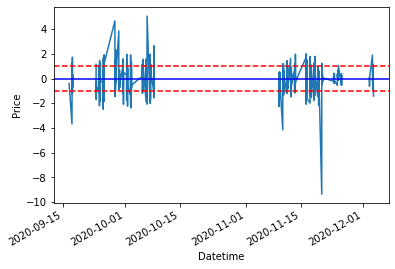

In [93]:
def rolling_zscore(x, lookback):
    return (x - x.rolling(lookback).mean()) / x.rolling(lookback).std()

def plot_rolling_spread(data, symbols, lookback):
    # We get the spread of the data by subtracting the returns from eachother
    spread = data[symbols[0]] - data[symbols[1]]
    
    # Normalize the data so that the mean is centered and the standard deviation is 1 before plotting it. 
    # We implement lookbacks when determining our z-scores to introduce time-dependency into our analysis.
    rolling_zscore(spread, lookback).plot()
    plt.axhline(rolling_zscore(spread, lookback).mean(), c='b')
    plt.ylabel("Price")
    
    # If the z-score increases to above 1 we can short symbols[0] and long symbols[1] and 
    # if the z-score falls below -1 we can long symbols[0] and short symbols[1]. Once the z-score
    # goas back to around 0, we exit our previosly taken position.
    plt.axhline(1, c='r', ls='--')
    plt.axhline(-1, c='r', ls='--')
    
ticker_data = pd.DataFrame({'ADX': data['ADX'], 'DNP': data['DNP']})
return_data = pd.DataFrame({'ADX': returns['ADX'], 'DNP': returns['DNP']})
symbols = ['ADX', 'DNP']

#plot_rolling_spread(ticker_data, symbols, 100)
plot_rolling_spread(return_data, symbols, 100)

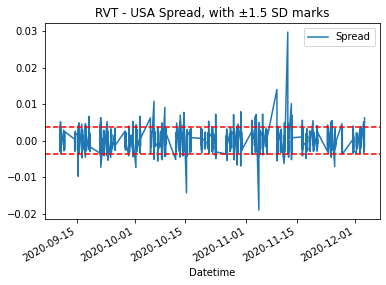

In [82]:
rvt, usa = common_data('RVT', 'USA')
spread = rvt - usa

avg = spread.mean()
std = spread.std()

spread.plot(label='Spread')
plt.axhline(spread.mean() + 1.5 * spread.std(), c = 'r', ls='--')
plt.axhline(spread.mean() - 1.5 * spread.std(), c = 'r', ls='--')
plt.legend()
plt.title("RVT - USA Spread, with ±1.5 SD marks")
plt.show();

In [65]:
consecutive = (spread > 100).copy()
for i in range(1, len(spread)):
    if spread[i] > avg + 1.5*std and spread[i-1] > avg + 1.5*std:
        consecutive[i] = True
    elif spread[i] < avg - 1.5*std and spread[i-1] < avg - 1.5*std:
        consecutive[i] = True
    else:
        consecutive[i] = False
# construct a boolean array of when spread is > 1.5 SD around mean for at least 30 minutes

In [66]:
sum(consecutive)

7

There were just 7 trading opportunities in the last 60 days for RVT and USA where the spread magnitude was > 1.5 SD compared to its mean for at least 30 minutes.

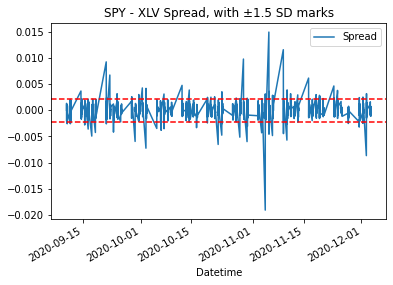

In [81]:
spy, xlv = common_data('SPY', 'XLV')
spread = spy - xlv

avg = spread.mean()
std = spread.std()

spread.plot(label='Spread')
plt.axhline(spread.mean() + 1.5 * spread.std(), c = 'r', ls='--')
plt.axhline(spread.mean() - 1.5 * spread.std(), c = 'r', ls='--')
plt.legend()
plt.title("SPY - XLV Spread, with ±1.5 SD marks")
plt.show();

In [63]:
consecutive = (spread > 100).copy()
for i in range(1, len(spread)):
    if spread[i] > avg + 1.5*std and spread[i-1] > avg + 1.5*std:
        consecutive[i] = True
    elif spread[i] < avg - 1.5*std and spread[i-1] < avg - 1.5*std:
        consecutive[i] = True
    else:
        consecutive[i] = False
# construct a boolean array of when spread is > 1.5 SD around mean for at least 30 minutes
sum(consecutive)

9

Just 9 trading opportunities (returns spread is > 1.5 SD larger/smaller than mean) in the past 60 days for XLV (US Healthcare) and SPY. Let's see which ETFs currently have a tradeable opportunity.

In [69]:
pairs_to_trade = []
for item in range(len(cointegrated_pairs_filtered)):
    t1, t2 = cointegrated_pairs_filtered.iloc[item, :2]
    a, b = common_data(t1, t2)
    spread = a - b
    
    avg, std = spread.mean(), spread.std()
    
    if (spread[-1] > avg + 1.5*std and spread[-2] > avg + 1.5*std) or (spread[-1] < avg - 1.5*std and spread[-2] < avg - 1.5*std):
        print(t1, t2)
        pairs_to_trade.append([t1,t2])

AWF EWA
AWF EWC
AWF USA
DSU USA
USA VVR


Just a handful of currently-tradeable pairs! Let's plot these out.

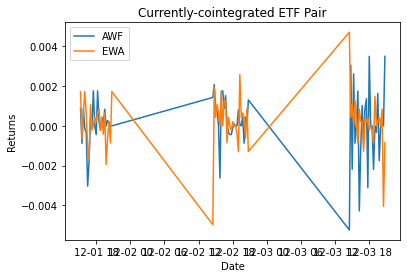

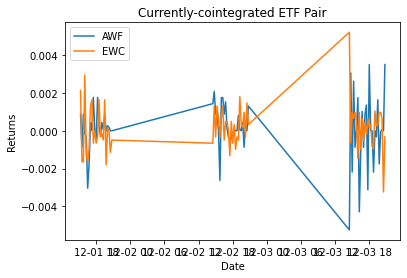

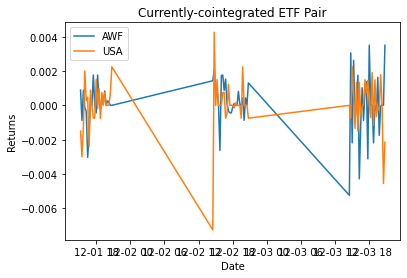

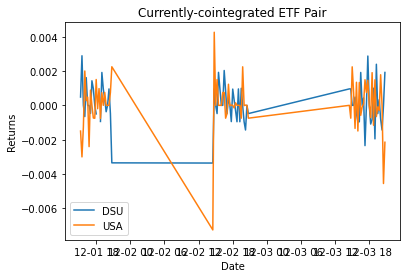

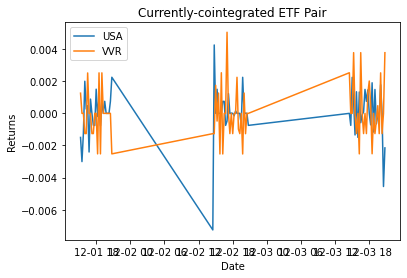

In [84]:
for t1, t2 in pairs_to_trade:
    plt.figure()
    plt.plot(returns[t1].iloc[-75:], label=t1)
    plt.plot(returns[t2].iloc[-75:], label=t2)
    plt.legend()
    plt.ylabel('Returns')
    plt.xlabel('Date')
    plt.title('Currently-cointegrated ETF Pair')
plt.show()

So we should:
  1) short AWF (AllianceBernstein Global High Income Fund - invests in risky bonds), long EWA (large- and mid-cap Australian market)

  2) short AWF, long EWC (large- and mid-cap Canadian market)

  3) short AWF, long USA (Liberty All-Star Equity Fund)
  
  4) short DSU (BlackRock Debt Strategies Fund - invests in corporate bonds), long USA
  
  5) short VVR (Invesco Senior Income Trust), long USA
  


How much should we long/short?

In [87]:
pairs_to_trade[4][0], pairs_to_trade[4][1] = pairs_to_trade[4][1], pairs_to_trade[4][0]
# put shorts first in each pair

In [90]:
for t1, t2 in pairs_to_trade:
    print("Short", round(data[t1][-1] / data[t2][-1], 2), "shares of", t1, "for each share of", t2, "you long.")

Short 0.49 shares of AWF for each share of EWA you long.
Short 0.37 shares of AWF for each share of EWC you long.
Short 1.71 shares of AWF for each share of USA you long.
Short 1.56 shares of DSU for each share of USA you long.
Short 0.59 shares of VVR for each share of USA you long.


We can exit our positions (buy back the shorted ETFs, sell the bought ETFs) once these spreads go back to 0 (or more in the other direction).

This is not a dynamic hedge ratio - it's just the one computed instantaneously at market close.